In [11]:
import pandas as pd
df = pd.read_csv("train.csv")
df["id"] = range(0, len(df))
df.info

<bound method DataFrame.info of                                                   address  label      id
0       Akarca Mah. Adnan Menderes Cad. 864.Sok. No:15...   8831       0
1       Cumhuriye Mah. Hükümet Cad. Sivriler İşhanı No...   8810       1
2       İsmet inönü mahallesi 2001 sokak no:2 Çeşme be...   3067       2
3       Gazeteci Hasan Tahsin Caddesi, No:10/3,  Gizem...   8210       3
4       Bitez mahallesi Adnan Menderes caddesi gündonu...   9675       4
...                                                   ...    ...     ...
848232     48. Sk. No.7 iç kapı no.5 yeşil mah. YEŞİL MAH   3142  848232
848233  Yiğitler mahallesi, Fevzi çakmak caddesi no:29...   4483  848233
848234   Girne Mahallesi 2132 Sokak No 25/A Kat 2 Daire 3   1589  848234
848235       Yeni Mah. 661. Sok. Çınar Apt. No:18 K:2 D:5   8220  848235
848236  Cami atık mah. Yıldırım cad. No100/2. Çalım sı...   1470  848236

[848237 rows x 3 columns]>

In [12]:
pattern_neighbourhood = (
    r"\b(?:"
    r"mah"                
    r"|mh"                 
    r"|mahalle"            
    r"|mahallesi"          
    r"|mahal"              
    r"|mahalesi"           
    r"|mahalesı"          
    r"|mahlesi"            
    r"|mahallle"           
    r"|mahalleesi"         
    r"|mahallsi"  
    r"|mmahalle" 
    r"|mahhalle"        
    r")\.?\b"
)

mask_neighbourhood = df["address"].str.contains(pattern_neighbourhood, case=False, na=False, regex=True)

neighbour_included_ids = set(df.loc[mask_neighbourhood, "id"])

In [13]:
pattern_street = (
    r"\b(?:"
    r"sk"           
    r"|sok"         
    r"|sokak"       
    r"|sokakı"      
    r"|sokağı"      
    r"|sokagı"      
    r"|sokagi"      
    r"|sokag"        
    r"|sokaki"              
    r")\.?\b"
)

mask_street = df["address"].str.contains(pattern_street, case=False, na=False, regex=True)

street_included_ids = set(df.loc[mask_street, "id"])

In [14]:
pattern_boulevard = (
    r"\b(?:"
    r"blv"          
    r"|blvr"        
    r"|bulv"        
    r"|bulvar"      
    r"|bulvarı"     
    r"|bulvari"     
    r"|bulvarl"     
    r"|bulbar"             
    r")\.?\b"
)

mask_boulevard = df["address"].str.contains(pattern_boulevard, case=False, na=False, regex=True)

boulevard_included_ids = set(df.loc[mask_boulevard, "id"])

In [15]:

pattern_site_building = (
    r"\b(?:"
    r"site(?:si|sı|su|sü)?"
    r"|apart(?:man[ıi])?"
    r"|apt"
    r"|rezidans"
    r"|residence"
    r"|blok"
    r"|tower"
    r"|plaza"
    r"|iş\s?h(?:an[ıi])?"   
    r"|konut(?:ları)?"
    r")\b"
)

mask_site_building = df["address"].str.contains(pattern_site_building, case=False, na=False, regex=True)

site_building_ids = set(df.loc[mask_site_building, "id"])

In [16]:
pattern_apartment_no = (
    r"\b(?:"
    r"d[.: -]?\s?\d+"        # D:3, D-3, D.3, D 3
    r"|daire\s?\d+"          # daire 3
    r"|dai?re\s?\d+"         # daıre 3 (ı/i varyantı)
    r")\b"
)

mask_apartment_no = df["address"].str.contains(pattern_apartment_no, case=False, na=False, regex=True)

apartment_ids = set(df.loc[mask_apartment_no, "id"])

In [17]:
pattern_building_no = (
    r"\b(?:"
    r"no[.: -]?\s?\d+[a-zA-Z]?"   # No:5, No.5, No 5, No-5, No:5A
    r"|numara\s?\d+[a-zA-Z]?"     # Numara 5, Numara 12B
    r"|\d{1,4}[/-]?\d*[a-zA-Z]?"  # 5, 5A, 10/B, 12-14, 6/4
    r")\b"
)

mask_building_no = df["address"].str.contains(pattern_building_no, case=False, na=False, regex=True)

building_no_ids = set(df.loc[mask_building_no, "id"])

In [18]:
pattern_avenue = (
    r"\b(?:"
    r"cd\.?"              # Cd, Cd.
    r"|cad\.?"            # Cad, Cad.
    r"|cadd\.?"           # Cadd, Cadd.
    r"|cadde"             # Cadde
    r"|caddesi"           # Caddesi
    r"|caddesı"           # Caddesı
    r"|cadde[ıi]"         # Caddei, Caddeı
    r")\b"
)

mask_avenue = df["address"].str.contains(pattern_avenue, case=False, na=False, regex=True)

avenue_ids = set(df.loc[mask_avenue, "id"])

In [19]:
# --- Helper masks (recommended) ---
mask_number = (mask_building_no | mask_apartment_no)   # any number info present

mask_any_way = (mask_street | mask_avenue | mask_boulevard)     
mask_road_no = (mask_any_way & mask_number)                      
mask_road_no_missing = (mask_any_way & ~mask_number)            

# --- A: Core address (most specific): mahalle + street + avenue + number ---
ids_A = set(df.loc[(mask_neighbourhood & mask_avenue & mask_street), "id"])

# --- B: No neighbourhood but still fairly complete: (road + number) and no neighborhood ---
ids_B = set(df.loc[(~mask_neighbourhood & mask_road_no), "id"])

# --- C: Only "avenue" missing: mahalle + (street or boulevard) + number, and no avenue ---
ids_C = set(df.loc[(mask_neighbourhood & ~mask_avenue & (mask_street | mask_boulevard) & mask_number), "id"])

# --- D: Only "sokak" missing: mahalle + (avenue or boulevard) + number, and no street ---
ids_D = set(df.loc[(mask_neighbourhood & ~mask_street & (mask_avenue | mask_boulevard) & mask_number), "id"])

# --- E: Missing number but otherwise core-ish: mahalle + road, no number ---
ids_E = set(df.loc[(mask_neighbourhood & mask_road_no_missing), "id"])

# --- F: Site/Building-name dominant (only remaining after higher priority groups) ---
ids_F = set(df.loc[(mask_site_building & ~mask_neighbourhood & ~mask_any_way), "id"])

# --- G: "Contains boulevard" (catch-all). Put late: very broad, capture only leftovers ---
ids_G = set(df.loc[mask_boulevard, "id"])

# --- H: No street & no avenue: mahalle + number  ---
ids_H = set(df.loc[(mask_neighbourhood & ~mask_street & ~mask_avenue & mask_number), "id"])

# --- I: Mostly only province & district-like: no neighbourhood, no road, no number ---
ids_I = set(df.loc[(~mask_neighbourhood & ~mask_any_way & ~mask_number), "id"])

# --- J: Leftovers ---
ids_J = set(df.loc[~df["id"].isin(
    ids_A | ids_B | ids_C | ids_D | ids_E | ids_F | ids_G | ids_H | ids_I
), "id"])


In [24]:
import os
import pandas as pd
from pathlib import Path
import sys

# -- make sure we can import from ../src while running inside data/ --
here = Path.cwd()
root = next((p for p in [here, *here.parents] if (p / "src").exists()), here)
sys.path.insert(0, str(root / "src"))

# use your existing normalizer implementation
from address_matching.normalization import AddressNormalizer

# 1) Priority order (most specific first; broad catch-alls later)
priority_groups = [
    ("A", "Complete core address", "ids_A"),
    ("C", "Only avenue missing", "ids_C"),
    ("D", "Only street missing", "ids_D"),
    ("E", "Missing building/apartment number", "ids_E"),
    ("B", "No neighbourhood (road + number)", "ids_B"),
    ("H", "No street & no avenue (mahalle + number)", "ids_H"),
    ("F", "Site/Building name dominant", "ids_F"),
    ("G", "Contains boulevard", "ids_G"),
    ("I", "Province & district only", "ids_I"),
    ("J", "Other rare/irregular cases", "ids_J"),
]

# 2) Map group code to its corresponding ID set (ids_* must already be defined in the notebook)
id_sets = {
    "A": ids_A,
    "B": ids_B,
    "C": ids_C,
    "D": ids_D,
    "E": ids_E,
    "F": ids_F,
    "G": ids_G,
    "H": ids_H,
    "I": ids_I,
    "J": ids_J,
}

# 3) Build an ID -> group map that respects the priority order
id2group = {}
for code, _, _ in priority_groups:
    for _id in id_sets.get(code, set()):
        if _id not in id2group:
            id2group[_id] = code

# 4) Attach the group to the DataFrame
df["group"] = df["id"].map(id2group)

# 5) Keep only rows that received a group
df_grouped = df.dropna(subset=["group"]).copy()

# --- NEW: normalize punctuation using your existing method in src/address_matching/normalization ---
normalizer = AddressNormalizer()
df_grouped["normalized_address"] = df_grouped["address"].astype(str).apply(
    normalizer.normalize_punctuation_only
)

# 6) Write a single CSV with all grouped rows in the requested order
out_cols = ["normalized_address", "label", "id", "group"]
df_grouped[out_cols].sort_values(["group", "id"]).to_csv("grouped_addresses.csv", index=False)

# 7) Optionally write one CSV per group (same column order)
os.makedirs("groups_csv", exist_ok=True)
for code, _, _ in priority_groups:
    sub = df_grouped[df_grouped["group"] == code]
    if not sub.empty:
        sub[out_cols].sort_values(["id"]).to_csv(f"groups_csv/group_{code}.csv", index=False)

# 8) Quick summary
print("Total assigned rows:", len(df_grouped))
print(df_grouped["group"].value_counts().sort_index())

# 9) Verify against expected distribution for A–J 
expected = {"A":80,"B":30,"C":24,"D":22,"E":22,"F":24,"G":12,"H":12,"I":12, "J":12}
for code, exp in expected.items():
    got = (df_grouped["group"] == code).sum()
    print(f"Group {code}: expected {exp}, got {got}")


Total assigned rows: 848237
group
A     13632
B    221936
C    381165
D    125965
E      7376
F      9700
G       772
H     51035
I      8638
J     28018
Name: count, dtype: int64
Group A: expected 80, got 13632
Group B: expected 30, got 221936
Group C: expected 24, got 381165
Group D: expected 22, got 125965
Group E: expected 22, got 7376
Group F: expected 24, got 9700
Group G: expected 12, got 772
Group H: expected 12, got 51035
Group I: expected 12, got 8638
Group J: expected 12, got 28018


Found 10 files under ../groups_csv

=== Token summary (A2E vs F2J) ===
Group  Sentences  Mean tokens/sent  Median      Std  Min  P25  P75   Max
  A2E     750074         13.767003    13.0 4.712331  2.0 10.0 16.0  59.0
  F2J      98163         11.978200    11.0 4.921034  1.0  9.0 15.0 237.0

=== Token-count frequency table (head) ===
 tokens  A2E_freq  F2J_freq
      1       0.0     122.0
      2     111.0     713.0
      3     306.0     948.0
      4    2714.0    1723.0
      5    5391.0    3076.0
      6   14757.0    4379.0
      7   20624.0    5405.0
      8   40464.0    7264.0
      9   44576.0    7898.0
     10   64974.0    8976.0
     11   63866.0    8959.0
     12   70038.0    8498.0
     13   68665.0    7560.0
     14   62509.0    6657.0
     15   57204.0    5470.0
     16   49285.0    4462.0
     17   39819.0    3888.0
     18   34648.0    2917.0
     19   26042.0    2451.0
     20   21254.0    1855.0


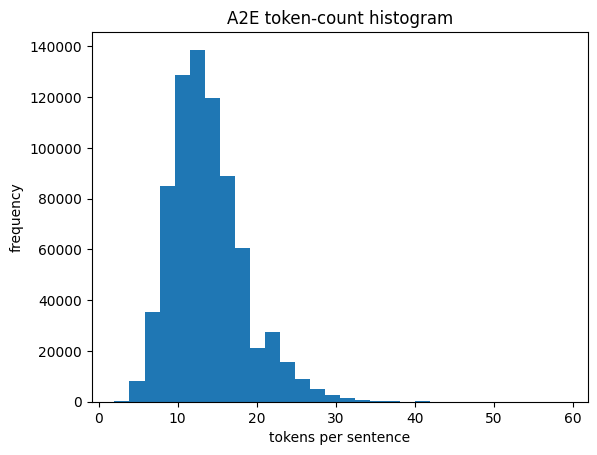

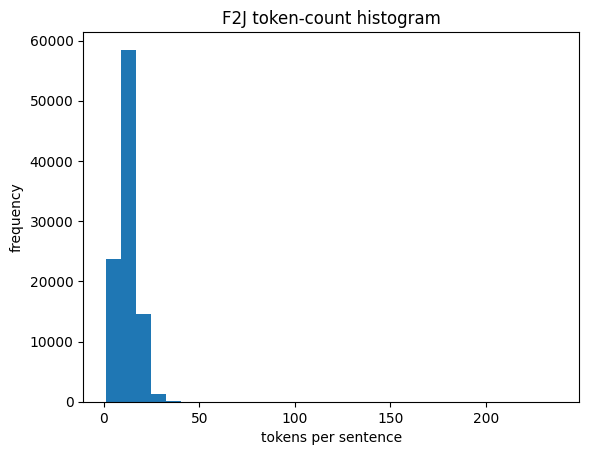

In [11]:
# Minimal A→E vs F→J token stats from ORIGINAL grouped CSVs
# Assumes you're running from data/goldset and files live in ../groups_csv/group_*.csv
# Assumes column: normalized_address

from pathlib import Path
import re
import pandas as pd
import numpy as np

FILES = sorted((Path.cwd().parent / "groups_csv").glob("group_*.csv"))
print(f"Found {len(FILES)} files under ../groups_csv")

# --- Optional: use your normalizer (if available) for punctuation handling ---
def _try_import_normalizer():
    try:
        # add project root if 'src' not on path
        here = Path.cwd()
        for p in [here] + list(here.parents):
            if (p / "src").exists():
                import sys
                sys.path.insert(0, str(p))
                break
        from src.address_matching import AddressNormalizer
        return AddressNormalizer()
    except Exception:
        return None

NORMALIZER = _try_import_normalizer()

def normalize_punct(s: str) -> str:
    s = str(s)
    if NORMALIZER is not None:
        try:
            return NORMALIZER.normalize_punctuation_only(s)
        except Exception:
            pass
    # fallback: strip commas & dots, keep ":" and "/" (to be split as separate tokens)
    s = s.replace(",", " ").replace(".", " ")
    return re.sub(r"\s+", " ", s).strip()

def split_with_punct(text: str):
    text = normalize_punct(text)
    out = []
    for token in text.split():
        cur = ""
        for ch in token:
            if ch in ":/":
                if cur:
                    out.append(cur); cur = ""
                out.append(ch)
            else:
                cur += ch
        if cur:
            out.append(cur)
    return out

A2E_SET = set("ABCDE")
F2J_SET = set("FGHIJ")

def infer_group_from_filename(path: Path) -> str | None:
    m = re.search(r"group[_\-]?([A-Za-z])\.csv$", path.name, flags=re.IGNORECASE)
    letter = m.group(1).upper() if m else None
    if not letter: return None
    if letter in A2E_SET: return "A2E"
    if letter in F2J_SET: return "F2J"
    return None

a2e_counts, f2j_counts = [], []

for fp in FILES:
    grp = infer_group_from_filename(fp)
    if grp is None:
        continue
    # Known format: utf-8, auto/comma sep, column 'normalized_address'
    df = pd.read_csv(fp, encoding="utf-8")
    if "normalized_address" not in df.columns:
        continue
    for s in df["normalized_address"].astype(str):
        s = s.strip()
        if not s:
            continue
        n_tok = len(split_with_punct(s))
        if grp == "A2E":
            a2e_counts.append(n_tok)
        else:
            f2j_counts.append(n_tok)

def summarize(name, arr):
    arr = np.array(arr, dtype=float) if arr else np.array([], dtype=float)
    return {
        "Group": name,
        "Sentences": int(arr.size),
        "Mean tokens/sent": float(arr.mean()) if arr.size else float("nan"),
        "Median": float(np.median(arr)) if arr.size else float("nan"),
        "Std": float(arr.std(ddof=1)) if arr.size > 1 else (0.0 if arr.size == 1 else float("nan")),
        "Min": float(arr.min()) if arr.size else float("nan"),
        "P25": float(np.percentile(arr, 25)) if arr.size else float("nan"),
        "P75": float(np.percentile(arr, 75)) if arr.size else float("nan"),
        "Max": float(arr.max()) if arr.size else float("nan"),
    }

summary_df = pd.DataFrame([summarize("A2E", a2e_counts), summarize("F2J", f2j_counts)])
print("\n=== Token summary (A2E vs F2J) ===")
print(summary_df.to_string(index=False))

# Token-count frequency table (for quick distribution comparison)
def freq_df(arr, name):
    vc = pd.Series(arr).value_counts().sort_index()
    return pd.DataFrame({"tokens": vc.index, f"{name}_freq": vc.values})

freq_a2e = freq_df(a2e_counts, "A2E")
freq_f2j = freq_df(f2j_counts, "F2J")
freq = pd.merge(freq_a2e, freq_f2j, on="tokens", how="outer").fillna(0).sort_values("tokens")

print("\n=== Token-count frequency table (head) ===")
print(freq.head(20).to_string(index=False))

# Optional: quick histograms (requires matplotlib installed)
try:
    import matplotlib.pyplot as plt
    if len(a2e_counts):
        plt.figure()
        plt.hist(a2e_counts, bins=30)
        plt.title("A2E token-count histogram")
        plt.xlabel("tokens per sentence"); plt.ylabel("frequency")
        plt.show()
    if len(f2j_counts):
        plt.figure()
        plt.hist(f2j_counts, bins=30)
        plt.title("F2J token-count histogram")
        plt.xlabel("tokens per sentence"); plt.ylabel("frequency")
        plt.show()
except Exception as e:
    print(f"[INFO] Skipping histograms (matplotlib not available): {e}")


Searching in: /Users/byege/localhost/data/synth_data
Found 2 files
  • synth_group_A2E.conll
  • synth_group_F2J.conll
[OK] synth_group_A2E.conll     A2E=  1000 F2J=     0
[OK] synth_group_F2J.conll     A2E=     0 F2J=  1000

=== Synthetic CoNLL — Token summary (A2E vs F2J) ===
Group  Sentences  Mean tokens/sent  Median      Std  Min  P25  P75  Max
  A2E       1000            14.283    14.0 3.277446  7.0 12.0 16.0 27.0
  F2J       1000            11.948    12.0 3.827002  3.0  9.0 15.0 36.0

=== Synthetic CoNLL — Token-count frequency table (head) ===
 tokens  A2E_freq  F2J_freq
      3       0.0       3.0
      4       0.0       4.0
      5       0.0      22.0
      6       0.0      43.0
      7       1.0      39.0
      8      15.0      67.0
      9      38.0      77.0
     10      64.0      94.0
     11      88.0     143.0
     12     109.0     125.0
     13     130.0      65.0
     14     108.0      55.0
     15     118.0      70.0
     16     109.0      88.0
     17      54.0      

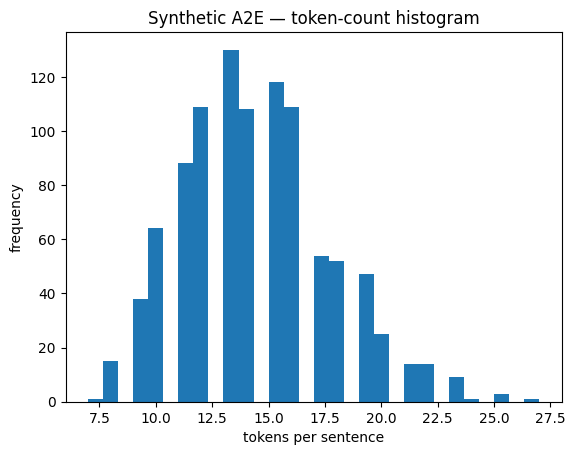

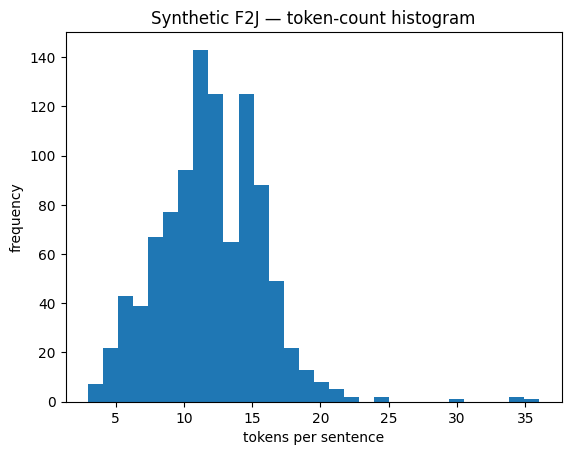

In [37]:
# === Synthetic CoNLL stats (A→E vs F→J) ===
# Looks under ../synth_data for *.conll / *.txt and computes tokens-per-sentence
# per group (A2E vs F2J), based on the group label present in each header line
# (e.g., "... , 69866, A2E"). Falls back to filename inference if needed.

from pathlib import Path
import re
import pandas as pd
import numpy as np

SYNTH_DIR = Path.cwd().parent / "synth_data"
PATTERNS = ["*.conll", "*.conl", "*.txt"]

# --- Discover files ---
files = []
for pat in PATTERNS:
    files.extend(sorted(SYNTH_DIR.glob(pat)))

print(f"Searching in: {SYNTH_DIR}")
print(f"Found {len(files)} files")
for p in files[:10]:
    print("  •", p.name)

def infer_group_from_filename(path: Path) -> str | None:
    low = path.name.lower()
    if "a2e" in low: return "A2E"
    if "f2j" in low: return "F2J"
    return None

# --- Parse a single CoNLL file into A2E/F2J token counts ---
def parse_conll_counts(path: Path):
    a2e_counts, f2j_counts = [], []
    cur_count = 0
    cur_group = None

    with open(path, "r", encoding="utf-8") as f:
        for raw in f:
            line = raw.rstrip("\n")

            # Sentence boundary (blank line)
            if not line.strip():
                if cur_count > 0 and cur_group in ("A2E", "F2J"):
                    (a2e_counts if cur_group == "A2E" else f2j_counts).append(cur_count)
                cur_count = 0
                cur_group = None
                continue

            # Token line: "token<TAB>tag"
            if "\t" in line:
                # be safe: only count well-formed token-tag rows
                parts = line.split("\t")
                if len(parts) >= 2 and parts[0].strip() != "":
                    cur_count += 1
                continue

            # Header/meta line → extract group (e.g., "... , 69866, A2E")
            m = re.search(r"\b(A2E|F2J)\b", line)
            if m:
                cur_group = m.group(1)
            else:
                # fallback to filename if header lacks group
                cur_group = infer_group_from_filename(path)

        # finalize last block if file doesn't end with blank line
        if cur_count > 0 and cur_group in ("A2E", "F2J"):
            (a2e_counts if cur_group == "A2E" else f2j_counts).append(cur_count)

    return a2e_counts, f2j_counts

# --- Aggregate all files ---
a2e_all, f2j_all = [], []
for fp in files:
    cA, cF = parse_conll_counts(fp)
    a2e_all.extend(cA)
    f2j_all.extend(cF)
    print(f"[OK] {fp.name:25s} A2E={len(cA):6d} F2J={len(cF):6d}")

# --- Summaries & distributions ---
def summarize(name, arr):
    arr = np.array(arr, dtype=float) if arr else np.array([], dtype=float)
    return {
        "Group": name,
        "Sentences": int(arr.size),
        "Mean tokens/sent": float(arr.mean()) if arr.size else float("nan"),
        "Median": float(np.median(arr)) if arr.size else float("nan"),
        "Std": float(arr.std(ddof=1)) if arr.size > 1 else (0.0 if arr.size == 1 else float("nan")),
        "Min": float(arr.min()) if arr.size else float("nan"),
        "P25": float(np.percentile(arr, 25)) if arr.size else float("nan"),
        "P75": float(np.percentile(arr, 75)) if arr.size else float("nan"),
        "Max": float(arr.max()) if arr.size else float("nan"),
    }

summary_df = pd.DataFrame([summarize("A2E", a2e_all), summarize("F2J", f2j_all)])
print("\n=== Synthetic CoNLL — Token summary (A2E vs F2J) ===")
print(summary_df.to_string(index=False))

# Frequency tables (token-count distributions)
def freq_df(arr, name):
    vc = pd.Series(arr).value_counts().sort_index()
    return pd.DataFrame({"tokens": vc.index, f"{name}_freq": vc.values})

freq_a2e = freq_df(a2e_all, "A2E") if a2e_all else pd.DataFrame(columns=["tokens","A2E_freq"])
freq_f2j = freq_df(f2j_all, "F2J") if f2j_all else pd.DataFrame(columns=["tokens","F2J_freq"])
freq_merged = pd.merge(freq_a2e, freq_f2j, on="tokens", how="outer").fillna(0).sort_values("tokens")

print("\n=== Synthetic CoNLL — Token-count frequency table (head) ===")
print(freq_merged.head(20).to_string(index=False))

# Optional: histograms (requires matplotlib)
try:
    import matplotlib.pyplot as plt
    if len(a2e_all):
        plt.figure()
        plt.hist(a2e_all, bins=30)
        plt.title("Synthetic A2E — token-count histogram")
        plt.xlabel("tokens per sentence"); plt.ylabel("frequency")
        plt.show()
    if len(f2j_all):
        plt.figure()
        plt.hist(f2j_all, bins=30)
        plt.title("Synthetic F2J — token-count histogram")
        plt.xlabel("tokens per sentence"); plt.ylabel("frequency")
        plt.show()
except Exception as e:
    print(f"[INFO] Skipping histograms (matplotlib not available): {e}")
